## Modelo 1

Se cargan las librerías.

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
import yaml

Se cargan los datos procesados.

In [4]:
segmentos = []

# Leer los archivos CSV segmentados y almacenarlos en la lista
for i in range(0,3):
    segmento = pd.read_csv(f'../data/processed/segmento_{i+1}.csv')
    segmentos.append(segmento)
# Concatenar los DataFrames de los segmentos en uno solo
df1 = pd.concat(segmentos, ignore_index=True)

Se separa el test del Dataframe original no balanceado para asegurar que los datos nuevos serán similares a los reales a predecir, manteniendo proporción en los datos

In [5]:
# Crear las variables para features y target
X = df1[['amt', 'city_pop', 'distancia', 'fraudes_por_Categoria',
       'fraudes_por_estado', 'fraudes_por_edad', 'fraudes_por_hora',
       'fraudes_por_día']]
y = df1['is_fraud']

# Separamos una muestra del DataFrame para probar el modelo
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.1,
                                                   random_state=0, stratify=y)


Una vez obtenido el test, se pasa a balancear los datos, tanto para aligerar la carga del entrenamiento, como para intentar que el modelo prediga mejor la clase minoritaría.

In [4]:
# Aplicamos undersampling a los datos
rus = RandomUnderSampler()

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# # Separamos el nuevo conjunto en X e y
# X_under = X_resampled
# y_under = y_resampled

In [5]:
# Define las proporciones deseadas para cada clase
sampling_strategy = {
    0: int(0.025 * len(y_train)),
    1: int(0.3 * len(y_train)) if int(0.3 * len(y_train)) <= sum(y_train == 1) else sum(y_train == 1)
}

rus = RandomUnderSampler(random_state=0, sampling_strategy=sampling_strategy)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

Se separa en train y test.

In [64]:
# # Volvemos a separar en test y train para que el test original y los datos del undersample no contaminen a examinar
# X_train_und, X_test_und, y_train_und, y_test_und = train_test_split(X_under,
#                                                    y_under,
#                                                    test_size = 0.2,
#                                                    random_state=0)

Con un GridSearch, se hiperparametriza un GradientBoostingClassifier.

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_scaled_test_resampled = scaler.transform(X_test)

In [7]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

In [9]:
# Aplicamos undersampling a los datos
rus = RandomUnderSampler()

X_resampled, y_resampled = rus.fit_resample(X_pca, y_resampled)

In [44]:
# Definir el pipeline con PCA
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('classifier', RandomForestClassifier())
])

# Definir los parámetros del GridSearchCV para Random Forest con PCA
rf_params= {
    'pca__n_components': [2,4,6,8],
    'classifier__class_weight': [{0: 1, 1: 100}],
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=rf_params, cv=3, scoring="roc_auc", verbose=10, n_jobs=-1)

# Ajustar el GridSearchCV
clf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [{0: 1, 1: 100}],
                         'pca__n_components': [2, 4, 6, 8]},
             scoring='roc_auc', verbose=10)

In [45]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)

{'classifier__class_weight': {0: 1, 1: 100}, 'pca__n_components': 8}
0.9777454036819782
Pipeline(steps=[('pca', PCA(n_components=8)),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 100}))])


In [46]:
predictions = clf.predict(X_test)

[[128873     44]
 [   247    504]]


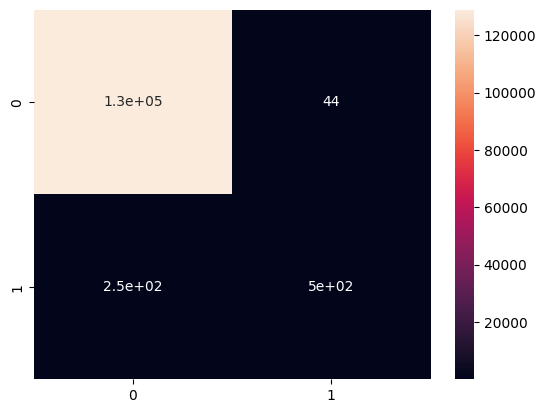

In [47]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [10]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [48]:
precision_score(y_test, predictions)

0.9197080291970803

In [49]:
recall_score(y_test, predictions)

0.6711051930758988

In [50]:
roc_auc_score(y_test, predictions)

0.8353819441026615

In [14]:
# Definir el pipeline con PCA
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('classifier', RandomForestClassifier())
])

# Definir los parámetros del GridSearchCV para Random Forest con PCA
rf_params= {
    'pca__n_components': [6,7,8],
    'classifier__class_weight': [{0: 1, 1: 100}],
    'classifier__max_depth': [6,7,8]
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=rf_params, cv=3, scoring="recall", verbose=10, n_jobs=-1)

# Ajustar el GridSearchCV
clf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [{0: 1, 1: 100}],
                         'classifier__max_depth': [6, 7, 8],
                         'pca__n_components': [6, 7, 8]},
             scoring='recall', verbose=10)

In [15]:
predictions = clf.predict(X_test)

[[126300   2617]
 [    54    697]]


<Axes: >

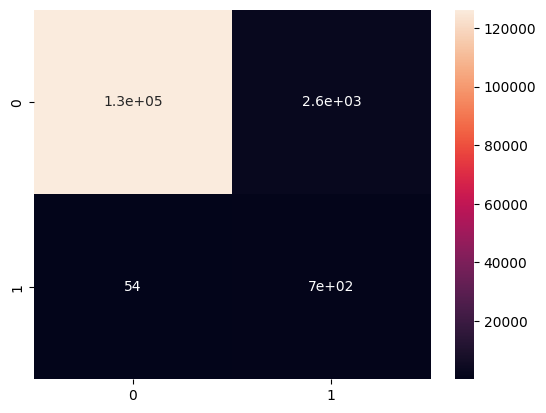

In [16]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True)

In [17]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.21031985515992757
Recall score: 0.9280958721704394
ROC AUC score: 0.9538979946500326


In [18]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)

{'classifier__class_weight': {0: 1, 1: 100}, 'classifier__max_depth': 8, 'pca__n_components': 6}
0.9218351478022134
Pipeline(steps=[('pca', PCA(n_components=6)),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 100},
                                        max_depth=8))])


In [ ]:
# Definir el pipeline con PCA
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('classifier', RandomForestClassifier())
])

# Definir los parámetros del GridSearchCV para Random Forest con PCA
rf_params= {
    'pca__n_components': [5,6,7],
    'classifier__class_weight': [{0: 1, 1: 75}],
    'classifier__max_depth': [10,11]
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=rf_params, cv=3, scoring="recall", verbose=10)

# Ajustar el GridSearchCV
clf.fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)

In [20]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)

{'classifier__class_weight': {0: 1, 1: 75}, 'classifier__max_depth': 10, 'pca__n_components': 5}
0.9129538901071269
Pipeline(steps=[('pca', PCA(n_components=5)),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 75},
                                        max_depth=10))])


[[126300   2617]
 [    54    697]]


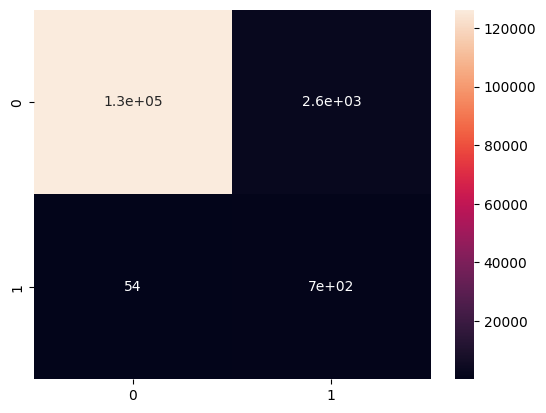

In [21]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [22]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.21031985515992757
Recall score: 0.9280958721704394
ROC AUC score: 0.9538979946500326


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

In [9]:
X_scaled = X_scaled.astype("float16")

In [77]:
X_scaled.dtype

dtype('float16')

In [81]:
x_test.dtype

dtype('float64')

In [10]:
X_test = X_test.astype("float16")

In [11]:
y_train = y_train.astype("float16")

In [85]:
# Definir el pipeline con PCA
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('classifier', RandomForestClassifier())
])

# Definir los parámetros del GridSearchCV para Random Forest con PCA
rf_params= {
    'pca__n_components': np.arange(1,9),
    'classifier__class_weight': [{0: 1, 1: 50}],
    'classifier__max_depth': [15]
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=rf_params, cv=3, scoring="roc_auc", verbose=10)

# Ajustar el GridSearchCV
clf.fit(X_scaled, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3; 1/32] START classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=5, pca__n_components=1
[CV 1/3; 1/32] END classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=5, pca__n_components=1;, score=0.814 total time= 1.5min
[CV 2/3; 1/32] START classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=5, pca__n_components=1
[CV 2/3; 1/32] END classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=5, pca__n_components=1;, score=0.685 total time= 1.6min
[CV 3/3; 1/32] START classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=5, pca__n_components=1
[CV 3/3; 1/32] END classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=5, pca__n_components=1;, score=0.638 total time= 1.6min
[CV 1/3; 2/32] START classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=5, pca__n_components=2
[CV 1/3; 2/32] END classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=5, pca__n_components=2;

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__class_weight': [{0: 1, 1: 50}],
                         'classifier__max_depth': [5, 10, 15, 20],
                         'pca__n_components': array([1, 2, 3, 4, 5, 6, 7, 8])},
             scoring='roc_auc', verbose=10)

In [12]:
# Definir el pipeline con PCA
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('classifier', RandomForestClassifier())
])

# Definir los parámetros del GridSearchCV para Random Forest con PCA
rf_params= {
    'pca__n_components': [7],
    'classifier__class_weight': [{0: 1, 1: 50}],
    'classifier__max_depth': [15]
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=rf_params, cv=3, scoring="roc_auc", verbose=10)

# Ajustar el GridSearchCV
clf.fit(X_scaled, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, pca__n_components=7
[CV 1/3; 1/1] END classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, pca__n_components=7;, score=0.975 total time= 7.5min
[CV 2/3; 1/1] START classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, pca__n_components=7
[CV 2/3; 1/1] END classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, pca__n_components=7;, score=0.977 total time= 7.7min
[CV 3/3; 1/1] START classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, pca__n_components=7
[CV 3/3; 1/1] END classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, pca__n_components=7;, score=0.981 total time= 6.8min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__class_weight': [{0: 1, 1: 50}],
                         'classifier__max_depth': [15],
                         'pca__n_components': [7]},
             scoring='roc_auc', verbose=10)

In [86]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)

{'classifier__class_weight': {0: 1, 1: 50}, 'classifier__max_depth': 15, 'pca__n_components': 7}
0.9778203756165526
Pipeline(steps=[('pca', PCA(n_components=7)),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 50},
                                        max_depth=15))])


[[128873     44]
 [   247    504]]


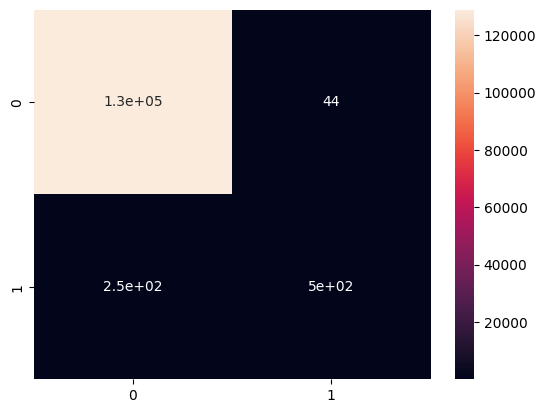

In [87]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [88]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.9197080291970803
Recall score: 0.6711051930758988
ROC AUC score: 0.8353819441026615


In [15]:
# Para escribir el archivo pickle
with open('../models/Model7/trained_model.pkl', 'wb') as archivo_salida:
    pickle.dump(clf.best_estimator_, archivo_salida)

# Para escribir el archivo YAML
with open("../models/Model7/model_config.yaml", "w") as f:
    yaml.dump(clf.best_params_, f)